In [1]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import altair as alt

In [3]:
df = pd.read_csv('../output/square@okhttp/experimental/okhttp@untreated.csv')
df.head()

,travisBuildNumber,travisBuildId,travisJobId,testName,index,duration,count,failures,errors,skipped
0,1,2685383,2685384,libcore.net.http.HttpResponseCacheTest,0,2.796,100,0,1,0
1,1,2685383,2685384,libcore.net.http.RawHeadersTest,1,0.001,2,0,0,0
2,1,2685383,2685384,libcore.net.http.URLConnectionTest,2,5.621,110,0,0,0
3,1,2685383,2685384,libcore.net.http.NewURLConnectionTest,3,0.000,1,0,0,0
4,1,2685383,2685384,libcore.net.spdy.SpdyConnectionTest,4,0.218,11,0,0,0


In [4]:
df['red'] = df['errors'] + df['failures']
dg = df.groupby('travisBuildNumber').agg({'red': 'sum', 'count': 'sum', 'duration': 'sum'}).reset_index()

## Do more tests fail over time at once?

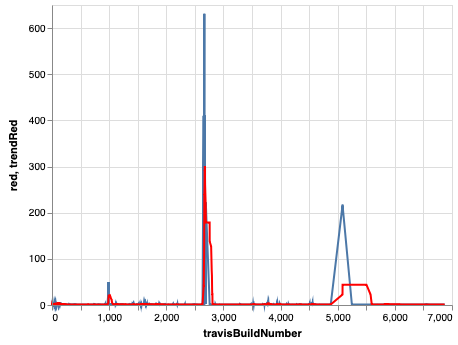

In [18]:
dg['trendRed'] = dg['red'].rolling(10, min_periods=1).mean()
alt.Chart(dg).mark_line().encode(x='travisBuildNumber', y='red') +  \
alt.Chart(dg).mark_line(color='red').encode(x='travisBuildNumber', y='trendRed')

## Do test suites grow over time?

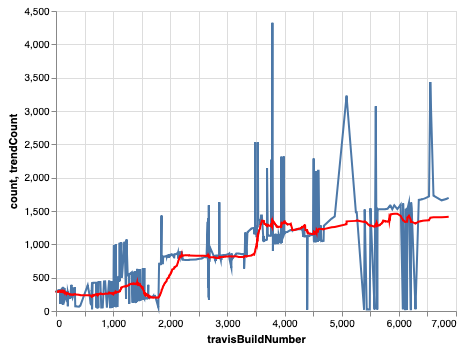

In [19]:
dg['trendCount'] = dg['count'].rolling(50, min_periods=1).mean()
alt.Chart(dg).mark_line().encode(x='travisBuildNumber', y='count') + \
alt.Chart(dg).mark_line(color='red').encode(x='travisBuildNumber', y='trendCount')

## Do test runs take longer over time?

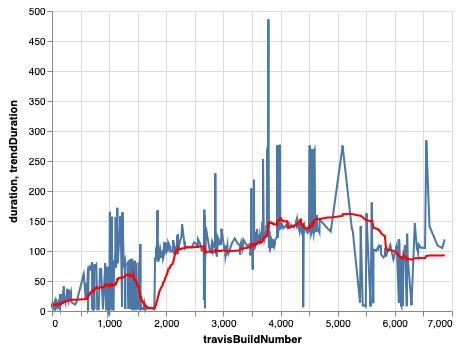

In [20]:
dg['trendDuration'] = dg['duration'].rolling(50, min_periods=1).mean()
alt.Chart(dg).mark_line().encode(x='travisBuildNumber', y='duration') + \
alt.Chart(dg).mark_line(color='red').encode(x='travisBuildNumber', y='trendDuration')

In [94]:
from testmining import folders
import os

os.environ['PRIO_QUALIFIER'] = 'experimental'
frames = []
for project_name, project_path in folders.projects():
    df = pd.read_csv(folders.strategy(project_path, 'untreated'))
    df = df[['travisBuildNumber', 'travisJobId', 'count']]
    df = df.groupby('travisJobId').agg({
        'travisBuildNumber': 'first',
        'count': {'tc': 'count', 'tm': 'sum'}
    })
    df.columns = df.columns.map(lambda x: '_'.join(x)).str.strip()
    df.reset_index(inplace=True)
    df = df.groupby('travisBuildNumber_first').agg({'count_tc': 'median', 'count_tm': 'median'}).reset_index()
    df['trend_tc'] = df['count_tc'].rolling(100, min_periods=1).mean()
    df['trend_tm'] = df['count_tm'].rolling(100, min_periods=1).mean()
    df['project'] = project_name.split('@')[1]
    frames.append(df)

df = pd.concat(frames)

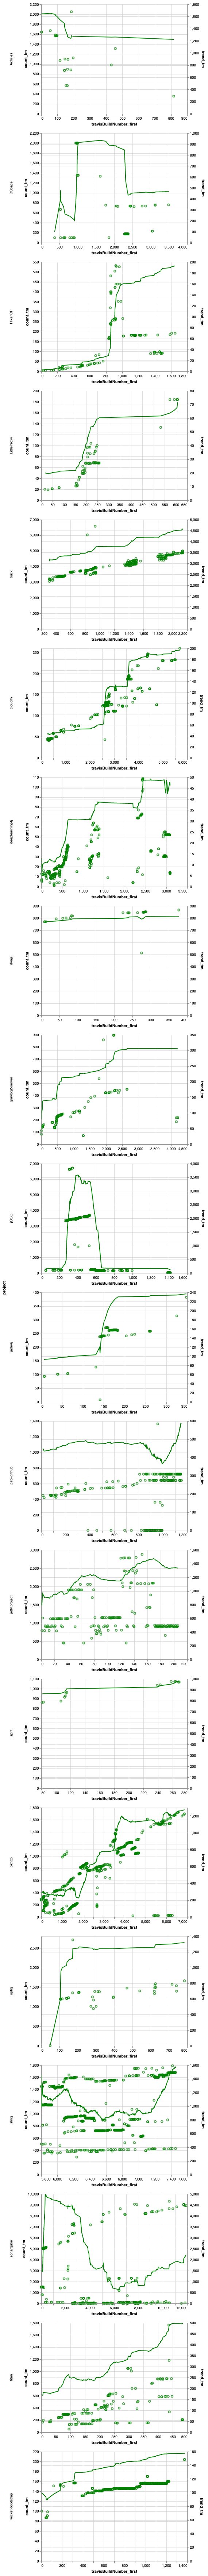

In [113]:

tc_scatter = alt.Chart().mark_point(color='orange').encode(
    x=alt.X('travisBuildNumber_first', scale=alt.Scale(zero=False)),
    y='count_tc',
) 

tc_trend = alt.Chart().mark_line(color='orange').encode(x='travisBuildNumber_first', y='trend_tc')

tm_scatter = alt.Chart().mark_point(color='green').encode(
    x=alt.X('travisBuildNumber_first', scale=alt.Scale(zero=False)),
    y='count_tm',
) 

tm_trend = alt.Chart().mark_line(color='green').encode(x='travisBuildNumber_first', y='trend_tm')

#c = ((tc_scatter + tc_trend) + (tm_scatter + tm_trend)).resolve_scale(y='independent')
c = (tm_scatter + tm_trend).resolve_scale(y='independent')

c.facet(data=df, row='project').resolve_scale(
    y='independent',
    x='independent',
)

## How does the faul detection efficiency develop over time?

In [9]:
dh = pd.read_csv('../output/square@okhttp/experimental-evaluation/square@okhttp-apfd.csv')[['untreated']].reset_index()

In [16]:
dh['trend'] = dh['untreated'].rolling(50, min_periods=1).mean()

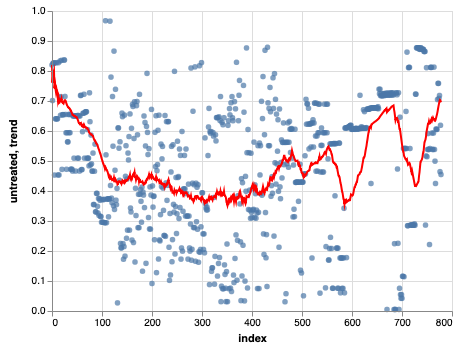

In [21]:
alt.Chart(dh).mark_point(filled=True).encode(x='index', y='untreated') + \
alt.Chart(dh).mark_line(color='red').encode(x='index', y='trend')